In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt

from numba import jit

In [2]:
###
# routines pulled from turboseti. These do taylor-tree style "dedoppler"
###
@jit(nopython=True)
def bitrev(inval, nbits):
    r"""
    This function bit-reverses the given value "inval" with the number of bits, "nbits".
    
    Parameters
    ----------
    inval : int
      Number to be bit-reversed.
    nbits : int
      The length of inval in bits. If user only wants the bit-reverse of a certain amount of bits of
      inval, nbits is the amount of bits to be reversed counting from the least significant (rightmost)
      bit. Any bits beyond this length will not be reversed and will be truncated from the result.
    
    Returns
    -------
    : int
      The bit-reverse of inval. If there are more significant bits beyond nbits, they are truncated.

    References
    ----------
    - R. Ramachandran, 10-Nov-97, nfra. -- Original C implementation.
    - H. Chen, 2014 -- Python version.
    - R. Elkins (texadactyl), 2020 -- Speedup.

    """
    if nbits <= 1:
        ibitr = inval
    else:
        ifact = 2**(nbits - 1)
        k = inval
        ibitr = (1 & k) * ifact
        for _ in range(2, nbits+1):
            k = k >> 1
            ifact = ifact >> 1
            if 1 & k:
                ibitr += ifact
    return ibitr

@jit(nopython=True)
def flt(outbuf, nchn):
    """
    This is a function to Taylor-tree-sum a data stream. It assumes that
    the arrangement of data stream is, all points in first spectra, all
    points in second spectra, etc. Data are summed across time.

    Parameters
    ----------
    outbuf : array_like
        Input data array, replaced by dedispersed data at the output.
    nchn : int
        Number of timesteps in the data.

    References
    ----------
    - R. Ramachandran, 07-Nov-97, nfra. -- Original algorithm.
    - A. Siemion, 2011 -- float/64 bit addressing (C-code)
    - H. Chen, 2014 -- python version
    - E. Enriquez + P.Schellart, 2016 -- cython version
    - L. Cruz, 2020 -- numba version

    """
    mlen = len(outbuf)
    nsamp = (mlen / nchn) - (2 * nchn)
    npts = nsamp + nchn
    nstages = int(np.log2(nchn))
    ndat1 = nsamp + 2 * nchn
    nmem = 1

    for istages in range(0, nstages):
        # print(f"doing stage {istages}")
        nmem *= 2
        nsec1 = int(nchn / nmem)
        nmem2 = nmem - 2

        for isec in range(0, nsec1):
            # print(f"isec {isec}")
            ndelay = -1
            koff = isec * nmem
            for ipair in range(0, nmem2 + 1, 2):
                # print(f"ipair {ipair}")
                ioff1 = int((bitrev(ipair, istages + 1) + koff) * ndat1)
                i2 = int((bitrev(ipair + 1, istages + 1) + koff) * ndat1)
                ndelay += 1
                ndelay2 = ndelay + 1
                nfin = int(npts + ioff1)

                # print(f"ioff1 : nfin = {ioff1} : {nfin}")
                for i1 in range(ioff1, nfin):
                    # print(f"running on {i1}")
                    itemp = outbuf[i1] + outbuf[i2 + ndelay]
                    outbuf[i2] = outbuf[i1] + outbuf[i2 + ndelay2]
                    outbuf[i1] = itemp
                    i2 += 1

    return outbuf


def bitrev_reshape_drifts(grid):
    '''
    wrap bitrev to fix the ordering of taylor-tree dedrifted output
    '''
    assert grid.ndim == 2
    number_drifts = grid.shape[0]
    for drift_index in range(number_drifts):
        drift_index_rev = bitrev(drift_index, int(np.log2(number_drifts)))
        if drift_index < drift_index_rev:
            tmp = np.copy(grid[drift_index,:])
            grid[drift_index,:] = grid[drift_index_rev,:]
            grid[drift_index_rev,:] = tmp
    return grid

In [3]:
###
# This is what bliss does-- direct linear rounding to accumulate down a line
###

# @jit()
def accumulate_linear(grid, timesteps):
    if grid.ndim == 1:
        grid = grid.reshape((timesteps, -1))
    accum = np.zeros_like(grid)
    slopes = np.arange(timesteps)
    for drift_index in range(timesteps):
        m = drift_index / (timesteps-1)
        for timestep in range(timesteps):
            freq_offset = int(round(m * timestep))
            selected_grid = grid[timestep, freq_offset:]
            if freq_offset > 0:
                accum[drift_index, :-freq_offset] += selected_grid
            else:
                accum[drift_index, :] += selected_grid

    return accum


In [4]:
###
# Data generators for benchmark comparisons
###

def build_binary_grid(timesteps, drift_slope):
    # build a grid that'll be large enough we don't overflow
    grid = np.zeros((timesteps, timesteps**2 // 2))
    # insert pixels along line
    for timestep in range(timesteps):
        freq_offset = int(round(drift_slope *  timestep))
        grid[timestep, freq_offset] = 1
    return grid


from math import floor, ceil
def build_interpolated_grid(timesteps, drift_slope):
    # build a grid that'll be large enough we don't overflow
    grid = np.zeros((timesteps, timesteps**2 // 2))
    # insert pixels along line
    for timestep in range(timesteps):
        freq_offset = (drift_slope *  timestep)
        d_floor = freq_offset - floor(freq_offset)
        d_ceil = ceil(freq_offset) - freq_offset
        grid[timestep, floor(freq_offset)] = 1-d_floor
        grid[timestep, ceil(freq_offset)] = 1-d_ceil
        
    return grid



def build_fft_grid(number_spectra, drift_slope):
    fourier_bins = number_spectra**2 // 4
    samples = fourier_bins * number_spectra

    s = np.exp(1.j * np.pi * ((-1 + drift_slope*(number_spectra-1)/fourier_bins * np.arange(samples)/samples) * np.arange(samples)))
    s = np.reshape(s, (number_spectra, -1))
    S = np.abs(np.fft.fftshift(np.fft.fft(s), axes=-1))
    return S




Sanity check a few grids

In [5]:
import matplotlib.gridspec as gridspec

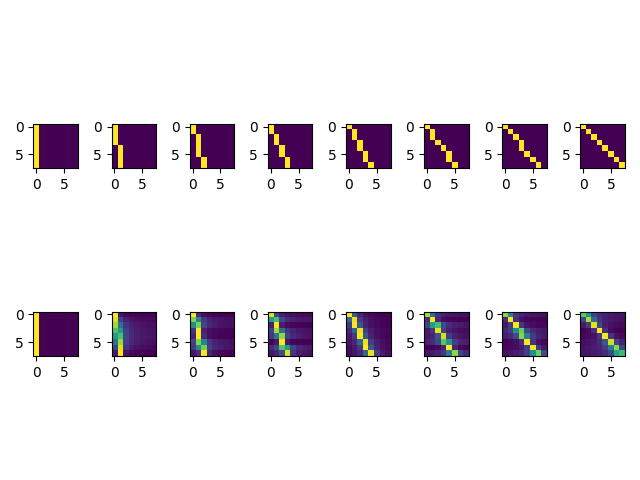

In [6]:

number_spectra = 8

fig = plt.figure()

gs = gridspec.GridSpec(2, number_spectra)

for unit_drifts in range(number_spectra):
    generated_bin_grid = build_binary_grid(number_spectra, unit_drifts/(number_spectra-1))
    generated_fft_grid = build_fft_grid(number_spectra, unit_drifts/(number_spectra-1))

    ax = fig.add_subplot(gs[0, unit_drifts])
    ax.imshow(generated_bin_grid[:,:number_spectra])
    ax = fig.add_subplot(gs[1, unit_drifts])
    ax.imshow(generated_fft_grid[:,:number_spectra])

plt.tight_layout()

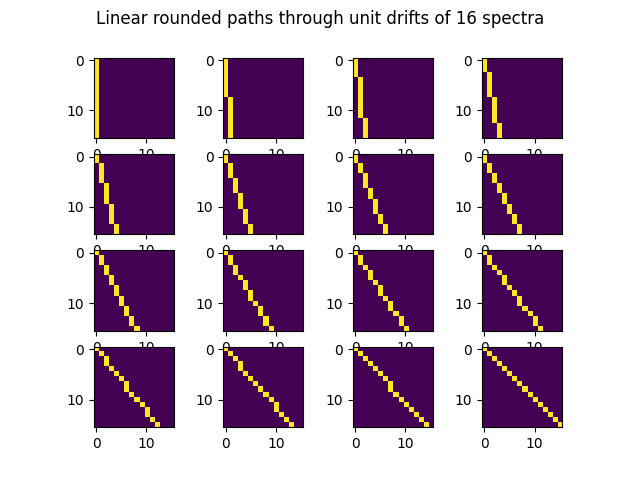

In [7]:

number_spectra = 16

fig = plt.figure()

plt.suptitle(f"Linear rounded paths through unit drifts of {number_spectra} spectra")
gs = gridspec.GridSpec(4, number_spectra//4)

for unit_drifts in range(number_spectra):
    generated_bin_grid = build_binary_grid(number_spectra, unit_drifts/(number_spectra-1))
    # generated_fft_grid = build_fft_grid(number_spectra, unit_drifts/(number_spectra-1))

    ax = fig.add_subplot(gs[unit_drifts//4, unit_drifts%4])
    ax.imshow(generated_bin_grid[:,:number_spectra])

# plt.tight_layout()

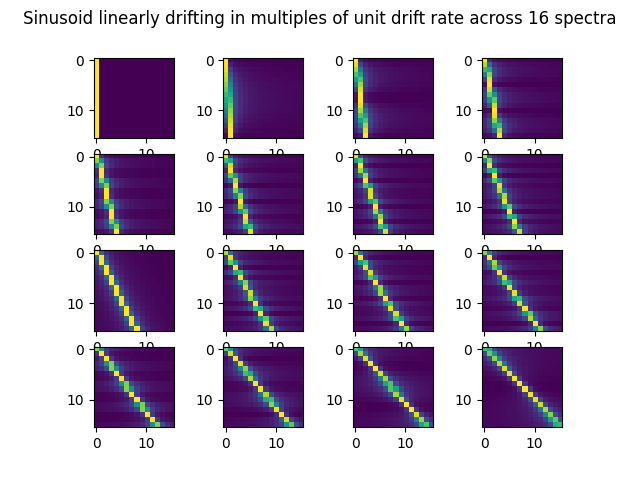

In [8]:

number_spectra = 16

fig = plt.figure()

plt.suptitle(f"Sinusoid linearly drifting in multiples of unit drift rate across {number_spectra} spectra")
gs = gridspec.GridSpec(4, number_spectra//4)

for unit_drifts in range(number_spectra):
    generated_fft_grid = build_fft_grid(number_spectra, unit_drifts/(number_spectra-1))

    ax = fig.add_subplot(gs[unit_drifts//4, unit_drifts%4])
    ax.imshow(generated_fft_grid[:,:number_spectra])

# plt.tight_layout()

[ 1.  2.  1. 16.  1.  4.  1.  4.  1.  2.  1.  8.  1.  8.  1.  4.]


Text(0.5, 0, 'Frequency Channel (fourier bins)')

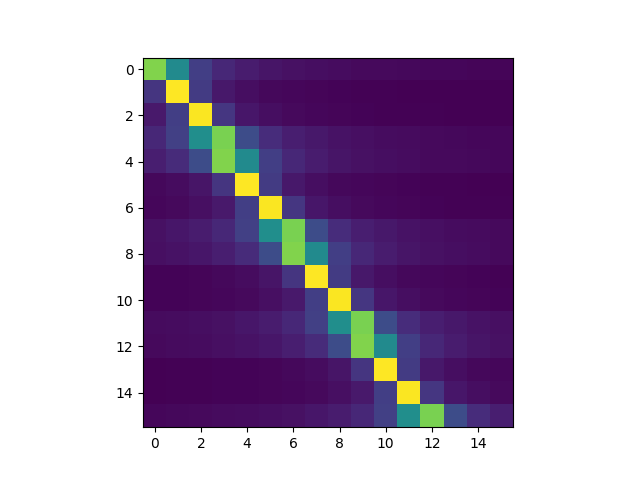

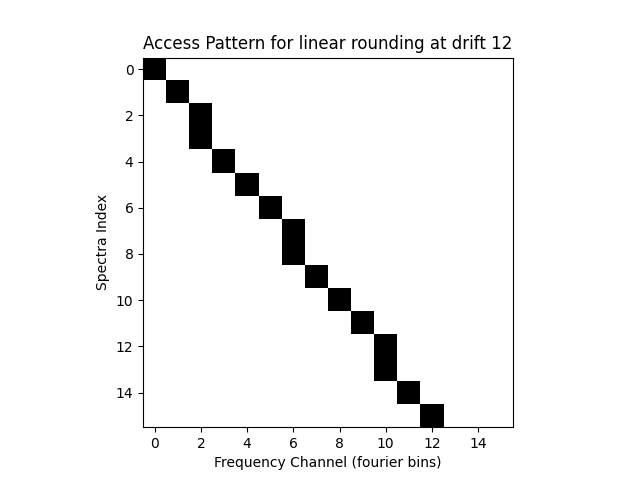

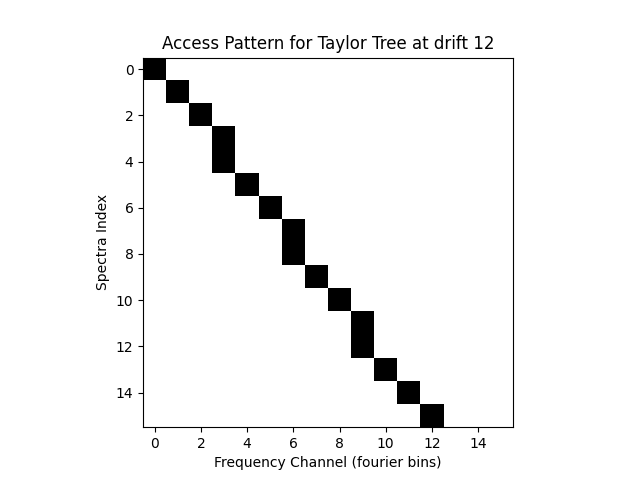

In [9]:

number_spectra = 16
generated_fft_grid = build_fft_grid(number_spectra, 12/(number_spectra-1))
plt.figure()
plt.imshow(generated_fft_grid[:,:number_spectra])

generated_bin_grid = build_binary_grid(number_spectra, 12/(number_spectra-1))
plt.figure()
plt.imshow(generated_bin_grid[:,:number_spectra], cmap="binary")
plt.title("Access Pattern for linear rounding at drift 12")
plt.ylabel("Spectra Index")
plt.xlabel("Frequency Channel (fourier bins)")

tree_12 = np.zeros((16, 256))
tree_12[0,0] = 1
tree_12[1,1] = 1
tree_12[2,2] = 1
tree_12[3,3] = 1
tree_12[4,3] = 1
tree_12[5,4] = 1
tree_12[6,5] = 1
tree_12[7,6] = 1
tree_12[8,6] = 1
tree_12[9,7] = 1
tree_12[10,8] = 1
tree_12[11,9] = 1
tree_12[12,9] = 1
tree_12[13,10] = 1
tree_12[14,11] = 1
tree_12[15,12] = 1

print (flt(tree_12.flatten(), 16).reshape((16, -1))[:,0])
plt.figure()
plt.imshow(tree_12[:,:16], cmap="binary")
plt.title("Access Pattern for Taylor Tree at drift 12")
plt.ylabel("Spectra Index")
plt.xlabel("Frequency Channel (fourier bins)")


In [10]:
print(np.arange(16) * 12/15)
print(np.round(np.arange(16) * 12/15))
      

[ 0.   0.8  1.6  2.4  3.2  4.   4.8  5.6  6.4  7.2  8.   8.8  9.6 10.4
 11.2 12. ]
[ 0.  1.  2.  2.  3.  4.  5.  6.  6.  7.  8.  9. 10. 10. 11. 12.]


In [11]:

number_spectras = [8, 10, 12, 14, 16, 18, 20, 22, 24, 28, 32, 36, 40, 44, 48, 56, 64, 72, 80, 88, 96, 112, 128, 144, 160, 196, 224, 256]
worst_loss_factors = []
best_loss_factors = []
median_loss_factors = []
mean_loss_factors = []

for number_spectra in number_spectras:
    all_factors = []
    for unit_drifts in range(number_spectra):

        generated_grid = build_fft_grid(number_spectra, unit_drifts/(number_spectra-1))

        tree_dedrift = flt(generated_grid.flatten(), number_spectra).reshape((number_spectra, -1))
        # tree_dedrift_mag = bitrev_reshape_drifts(tree_dedrift)[:,0][unit_drifts]
        tree_dedrift_mag = max(bitrev_reshape_drifts(tree_dedrift)[:,0])

        linear_dedrift = accumulate_linear(generated_grid.flatten(), number_spectra).reshape((number_spectra, -1))[:,0]
        # linear_dedrift_mag = linear_dedrift[unit_drifts]
        linear_dedrift_mag = max(linear_dedrift)

        all_factors.append(tree_dedrift_mag / linear_dedrift_mag)

    worst_loss_factors.append(min(all_factors))
    best_loss_factors.append(max(all_factors))
    median_loss_factors.append(np.median(all_factors))
    mean_loss_factors.append(np.mean(all_factors))




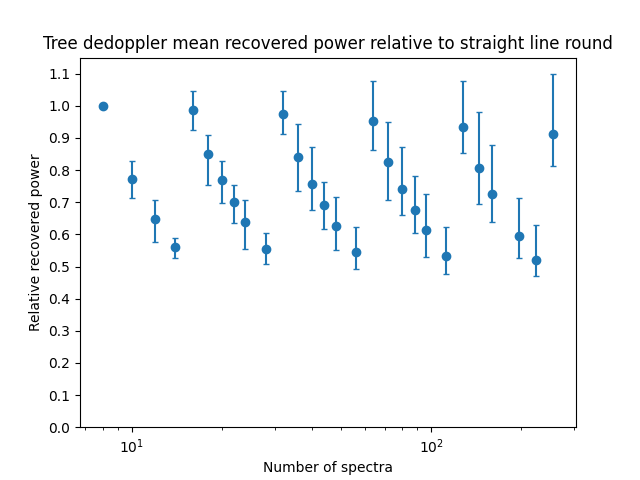

In [12]:
plt.figure()
plt.title("Tree dedoppler mean recovered power relative to straight line round")
relative_to = np.array(mean_loss_factors)
plt.errorbar(number_spectras, relative_to, yerr=(relative_to-np.array(worst_loss_factors), np.array(best_loss_factors)-relative_to), fmt="o", capsize=2)
plt.xlabel("Number of spectra")
plt.ylabel("Relative recovered power")
plt.ylim(0, 1.15)
plt.yticks(np.arange(0, 1.15, .1))

plt.xscale('log')


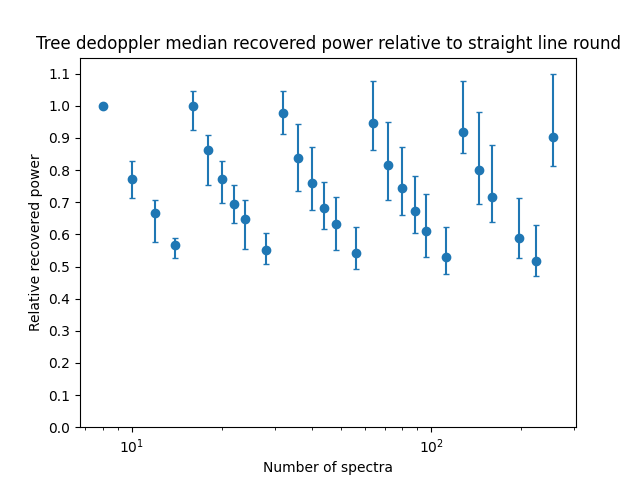

In [13]:
plt.figure()
plt.title("Tree dedoppler median recovered power relative to straight line round")
relative_to = np.array(median_loss_factors)
plt.errorbar(number_spectras, relative_to, yerr=(relative_to-np.array(worst_loss_factors), np.array(best_loss_factors)-relative_to), fmt="o", capsize=2)
plt.xlabel("Number of spectra")
plt.ylabel("Relative recovered power")
plt.ylim(0, 1.15)
plt.yticks(np.arange(0, 1.15, .1))

plt.xscale('log')
